# Detecting influenza epidemics using search engine query data
Ginsberg, J., Mohebbi, M. H., Patel, R. S., Brammer, L., Smolinski, M. S., & Brilliant, L. (2009). Detecting influenza epidemics using search engine query data. Nature, 457(7232), 1012–1014. https://doi.org/10.1038/nature07634
- The article describes a method for **detecting influenza epidemics using search engine query data**. By analyzing Google search queries to track influenza-like illnesses in the United States, the results are more timely than traditional surveillance systems and contribute to public health responses.

## Data
### Google Query Data
**Query fractions for the top 100 search queries**, sorted by mean Z-transformed correlation with CDC-provided ILI percentages across the nine regions of the United States. (XLS 5264 kb)  

Data publicly available from the authors: https://static-content.springer.com/esm/art%3A10.1038%2Fnature07634/MediaObjects/41586_2009_BFnature07634_MOESM271_ESM.xls

#### Table 1   |   Topics found in search queries which were found to be most correlated with CDC ILI data
<img src="pic/table1.png" width="600" height="400" alt="描述文字">

#### Data Example：
<img src="pic/table3.png" width="1000" height="400" alt="描述文字">


### CDC’s ILI Data
The influenza-like illness visits reported by sentinel medical institutions, including the percentage of visits, including the number of illnesses in different age groups, the total number of patients, and the weighted percentage of ILI.

The author used the **weighted version of CDC’s ILI activity level** as the estimation target.The weekly revisions of CDC’s ILI are available at the CDC website for all recorded seasons (from week 40 of a given year to week 20 of the subsequent year).   

Data publicly available from the website: [National, Regional, and State Level Outpatient Illness and Viral Surveillance](https://gis.cdc.gov/grasp/fluview/fluportaldashboard.html)

<img src="pic/site.png" width="800" height="400" alt="描述文字">

#### Data Example：
<img src="pic/table2.png" width="1000" height="400" alt="描述文字">

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [2]:
# Import search query data
file = "E:/2024计算社会科学夏校/hw/day6/"
quer_data = file + "41586_2009_BFnature07634_MOESM271_ESM.xls"
df = pd.read_excel(quer_data, sheet_name=1, header = 1)
df.head()

,Date,United States,New England Region,Mid-Atlantic Region,East North Central Region,West North Central Region,South Atlantic Region,East South Central Region,West South Central Region,Mountain Region,Pacific Region
0,2003-06-01,0.778,0.979,0.990,0.838,0.673,0.732,0.922,0.809,0.486,0.621
1,2003-06-08,0.850,0.932,0.806,0.879,0.839,0.852,0.479,0.800,1.383,1.008
2,2003-06-15,0.838,1.018,0.892,0.839,0.568,0.751,1.130,1.111,0.702,0.777
3,2003-06-22,0.828,0.615,1.149,0.676,0.730,0.867,1.149,0.498,0.936,0.734
4,2003-06-29,0.747,0.896,0.768,0.829,0.612,0.530,0.854,0.491,1.081,1.015


The table shows sheet1, the most relevant search query for CDC'ILI, and each sheet contains web searches for the country and nine regions.

Since Figure 2 of the article uses search query data from the mid-atlantic region to make predictions, I will also use this region here for reproduction, but later, I will use data from some other regions to make predictions to check the generalization ability of the model.

####   Figure 2   |   A comparison of model estimates for the mid-Atlantic region (black) against CDC-reported ILI percentages (red), including points over which the model was fit and validated.
<img src="pic/figure2.png" width="600" height="400" alt="描述文字">


To decide which queries would be included in the ILI-related query fraction, the author considered different sets of  n top-scoring queries. They measured the performance of these models based on the sum of the queries in each set, and picked n such that they obtained the best fit against out-of-sample ILI data across the nine regions.

#### Figure 1 | An evaluation of how many top-scoring queries to include in the ILI-related query fraction

<img src="pic/figure1.png" width="600" height="400" alt="描述文字">

Maximal performance at estimating out-of- sample points during cross-validation was obtained by summing **the top 45 search queries**. A steep drop in model performance occurs after adding query 81, which is ‘oscar nominations’.

In [3]:
# Choose Mid-Atlantic Region 
area = 'Mid-Atlantic Region'

# Combine 45 queries
dict = {'date': df['Date'].tolist()} # Turn the Date into a list, stored in the dictionary
for i in range(1, 46):
    if i % 5 ==0:
        print(i)
    df = pd.read_excel(quer_data, sheet_name=i, header = 1) # Read sheet, keep 2nd row
    dict['query'+str(i)] = df[area].tolist()
dat = pd.DataFrame.from_dict(dict)
dat.head()

5
10
15
20
25
30
35
40
45


,date,query1,query2,query3,query4,query5,query6,query7,query8,query9,...,query36,query37,query38,query39,query40,query41,query42,query43,query44,query45
0,2003-06-01,0.990,6.471,6.899,0.990,1.448,1.581,0.118,0.517,0.813,...,0.414,0.103,0.606,0.163,0.355,0.827,0.163,0.295,2.822,2.245
1,2003-06-08,0.806,6.063,6.992,0.964,1.227,1.647,0.123,0.280,0.596,...,0.543,0.158,0.561,0.210,0.210,1.577,0.228,0.193,2.664,2.050
2,2003-06-15,0.892,5.044,6.130,0.912,0.912,1.765,0.019,0.485,0.640,...,0.582,0.194,0.737,0.175,0.310,1.377,0.136,0.330,3.240,2.541
3,2003-06-22,1.149,5.033,5.054,0.710,0.668,2.068,0.104,0.230,0.564,...,0.272,0.125,0.522,0.167,0.313,1.587,0.230,0.292,2.318,2.088
4,2003-06-29,0.768,4.920,5.128,0.685,0.727,1.868,0.021,0.270,0.374,...,0.415,0.104,0.374,0.083,0.145,1.100,0.187,0.353,2.553,2.284


In [4]:
# Convert time series data columns to datetime type
dat['date'] = pd.to_datetime(dat['date'])

# Read CDC’s ILI activity level
df = {}
for i in range(0,7):
    full_path = file + "FluView_LineChart_Data-{}.csv".format(i)
    df[i] = pd.read_csv(full_path, skiprows = 1)

y = pd.concat([df[0], df[1], df[2], df[3], df[4], df[5], df[6]])

'''
keep data where date greater than 2003-06-01
according to https://www.epochconverter.com/weeks/2003, 2003-06-01 is the 23th week

'''
y = y[y['YEAR'] > 2002]
y = y[((y['YEAR']==2003)&(y['WEEK'] > 22)) | (y['YEAR'] > 2003) ][:dat['date'].size]

y = y['% WEIGHTED ILI']

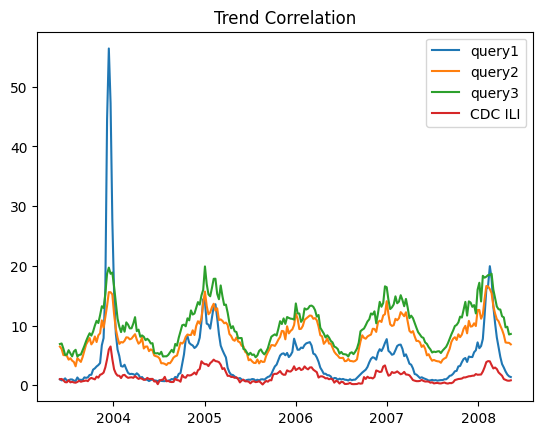

In [5]:
# Draw simple line graph to see the correlation of query and ILI
plt.plot(dat['date'], dat['query1'], label = 'query1')
plt.plot(dat['date'], dat['query2'], label = 'query2')
plt.plot(dat['date'], dat['query3'], label = 'query3')
plt.plot(dat['date'], y,  label = 'CDC ILI')
plt.legend()
plt.title('Trend Correlation')
plt.show()

In [6]:
dat['y'] = y.tolist() # Store y into *dat* dataset

dat.columns

Index(['date', 'query1', 'query2', 'query3', 'query4', 'query5', 'query6',
       'query7', 'query8', 'query9', 'query10', 'query11', 'query12',
       'query13', 'query14', 'query15', 'query16', 'query17', 'query18',
       'query19', 'query20', 'query21', 'query22', 'query23', 'query24',
       'query25', 'query26', 'query27', 'query28', 'query29', 'query30',
       'query31', 'query32', 'query33', 'query34', 'query35', 'query36',
       'query37', 'query38', 'query39', 'query40', 'query41', 'query42',
       'query43', 'query44', 'query45', 'y'],
      dtype='object')

In [7]:
# Create covariates that may affect the ILI activity level
# Create a time trend
dat['trend'] = range(1,len(dat)+1)

# Create a dummy variable indicating winter season
dat['winter'] = [1 if i.month in [12, 1, 2] else 0 for i in dat['date'] ]

# Create lagged variables
for i in range(1, 8):
    dat["lag_{}".format(i)] = dat['y'].shift(i)

# Fill the database with all missing values to 0.
dat = dat.fillna(0)

In [8]:
dat.head()

,date,query1,query2,query3,query4,query5,query6,query7,query8,query9,...,y,trend,winter,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,2003-06-01,0.990,6.471,6.899,0.990,1.448,1.581,0.118,0.517,0.813,...,1.010050,1,0,0.000000,0.000000,0.00000,0.00000,0.0,0.0,0.0
1,2003-06-08,0.806,6.063,6.992,0.964,1.227,1.647,0.123,0.280,0.596,...,1.050500,2,0,1.010050,0.000000,0.00000,0.00000,0.0,0.0,0.0
2,2003-06-15,0.892,5.044,6.130,0.912,0.912,1.765,0.019,0.485,0.640,...,0.825375,3,0,1.050500,1.010050,0.00000,0.00000,0.0,0.0,0.0
3,2003-06-22,1.149,5.033,5.054,0.710,0.668,2.068,0.104,0.230,0.564,...,0.508273,4,0,0.825375,1.050500,1.01005,0.00000,0.0,0.0,0.0
4,2003-06-29,0.768,4.920,5.128,0.685,0.727,1.868,0.021,0.270,0.374,...,0.487201,5,0,0.508273,0.825375,1.05050,1.01005,0.0,0.0,0.0


In [9]:
len(dat)

259

In [10]:
# Train an Elastic Net model
def train_the_model(X):
    # Normalized feature data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split training and test sets
    N = 50
    y = dat['y']
    X_train = X_scaled[:N,]
    X_test = X_scaled[N:,]
    y_train = y[:N]
    y_test = y[N:]
        
    # Elastic Net Regression
    cv_model = ElasticNetCV(l1_ratio=0.5, eps=1e-3, n_alphas=200, fit_intercept=True, precompute='auto', max_iter=500, tol=0.006, cv=10,
                            copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=0)

    # Train the model              
    cv_model.fit(X_train, y_train)

    # Calculate the optimal number of iterations, alpha, and ratio
    print('Best alpha: %.8f'%cv_model.alpha_)
    print('Best l1_ratio: %.3f'%cv_model.l1_ratio_)
    print('Iterations %d'%cv_model.n_iter_)

    # Store the predicted results
    y_train_pred = cv_model.predict(X_train)
    y_test_pred = cv_model.predict(X_test)

    # Calculate the R ² scores to evaluate the goodness of fit of the model: bigger is better
    print('Train r2 score: ', r2_score(y_train_pred, y_train))
    print('Test r2 score: ', r2_score(y_test_pred, y_test))
    
    # Calculate the MSE and RMSE: smaller is better
    train_mse = mean_squared_error(y_train_pred, y_train)
    test_mse = mean_squared_error(y_test_pred, y_test)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    
    print('Train RMSE: %.4f' % train_rmse)
    print('Test RMSE: %.4f' % test_rmse)   
    
    # Plot to see the difference between the predicted value and the true value
    date = dat['date']
    plt.style.use('ggplot')
    plt.rcParams.update({'figure.figsize': (15, 5)})
    plt.rcParams['font.size'] = 14
    plt.plot(date, y, label = 'ILI')
    plt.plot(date[N:], y_test_pred, label = 'Predicted ILI')
    plt.title(f'{area}')
    # 在图表下方添加注释
    plt.figtext(0.1, 0, f'{note}', ha='left', va='bottom')
    plt.legend()
    plt.show()

I chose the Elastic Net Regression because the number of features is relatively great, and they may express multicollinearity.

In [11]:
dat.columns

Index(['date', 'query1', 'query2', 'query3', 'query4', 'query5', 'query6',
       'query7', 'query8', 'query9', 'query10', 'query11', 'query12',
       'query13', 'query14', 'query15', 'query16', 'query17', 'query18',
       'query19', 'query20', 'query21', 'query22', 'query23', 'query24',
       'query25', 'query26', 'query27', 'query28', 'query29', 'query30',
       'query31', 'query32', 'query33', 'query34', 'query35', 'query36',
       'query37', 'query38', 'query39', 'query40', 'query41', 'query42',
       'query43', 'query44', 'query45', 'y', 'trend', 'winter', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7'],
      dtype='object')

Best alpha: 0.00643563
Best l1_ratio: 0.500
Iterations 40
Train r2 score:  0.9912224349594496
Test r2 score:  0.714398137749692
Train RMSE: 0.1178
Test RMSE: 0.4733


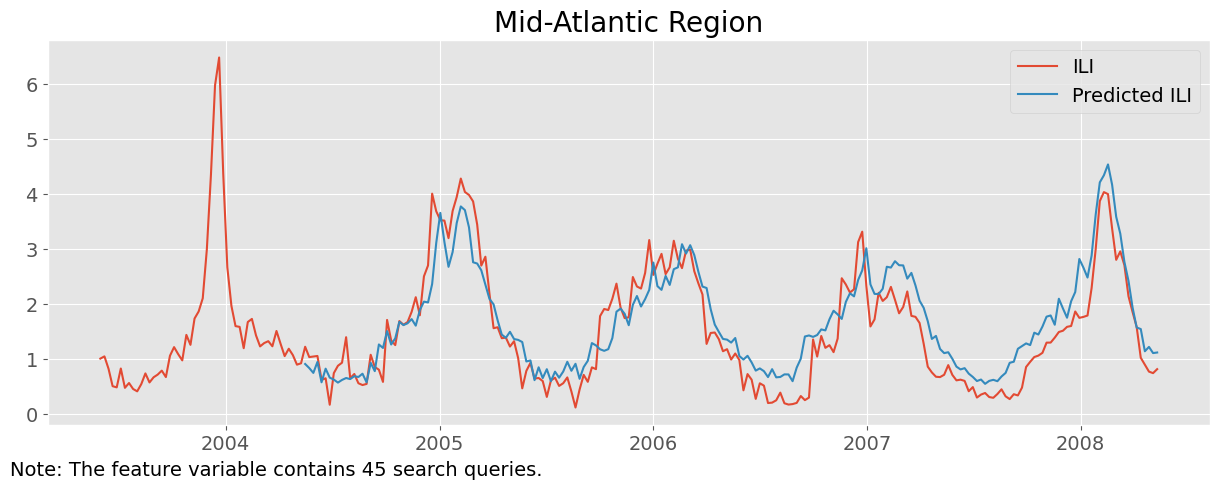

In [12]:
# Independent variables are only the queries
X = dat.drop( ['date', 'y', 'trend', 'winter', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7'], axis = 1)
# axis=1 indicates that the column was deleted

note = 'Note: The feature variable contains 45 search queries.'
train_the_model(X)


Best alpha: 0.00643563
Best l1_ratio: 0.500
Iterations 40
Train r2 score:  0.9912224349594496
Test r2 score:  0.714398137749692
Train RMSE: 0.1178
Test RMSE: 0.4733


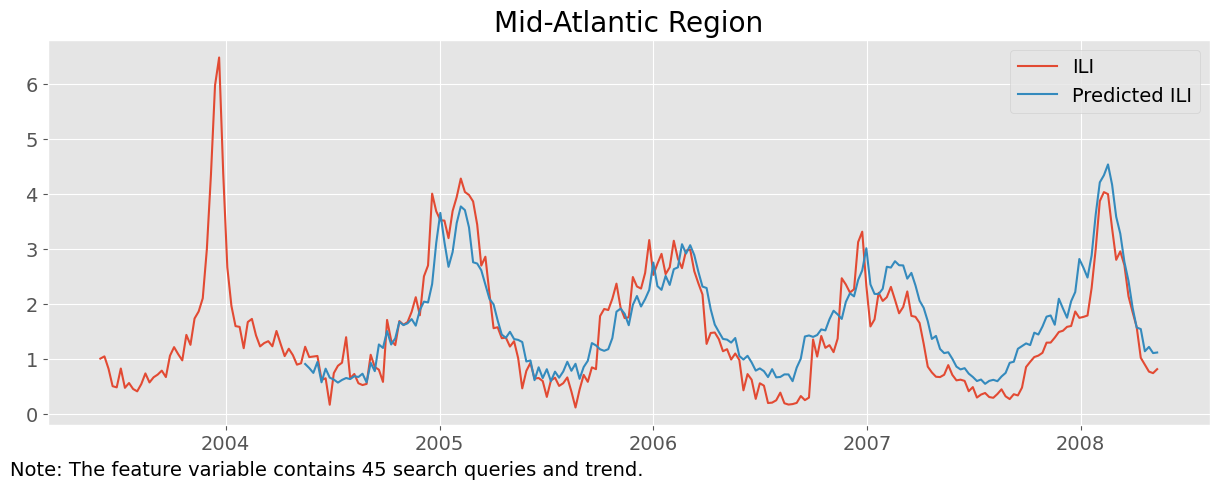

In [13]:
# search queries + trend
X = dat.drop( ['date', 'y', 'winter', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7'], axis = 1)

note = 'Note: The feature variable contains 45 search queries and trend.'
train_the_model(X)

Best alpha: 0.00643563
Best l1_ratio: 0.500
Iterations 41
Train r2 score:  0.9911642754468253
Test r2 score:  0.7269229957413517
Train RMSE: 0.1182
Test RMSE: 0.4682


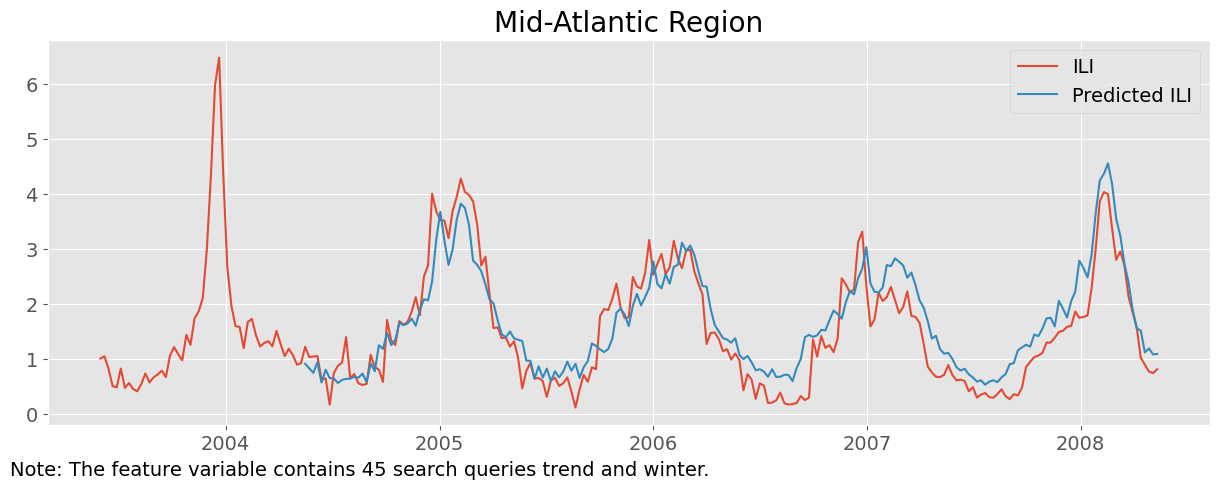

In [14]:
# search queries + trend + winter
X = dat.drop( ['date', 'y', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7'], axis = 1) 

note = 'Note: The feature variable contains 45 search queries trend and winter.'
train_the_model(X)

Best alpha: 0.00792581
Best l1_ratio: 0.500
Iterations 40
Train r2 score:  0.9913573919882007
Test r2 score:  0.7379772937875327
Train RMSE: 0.1169
Test RMSE: 0.4596


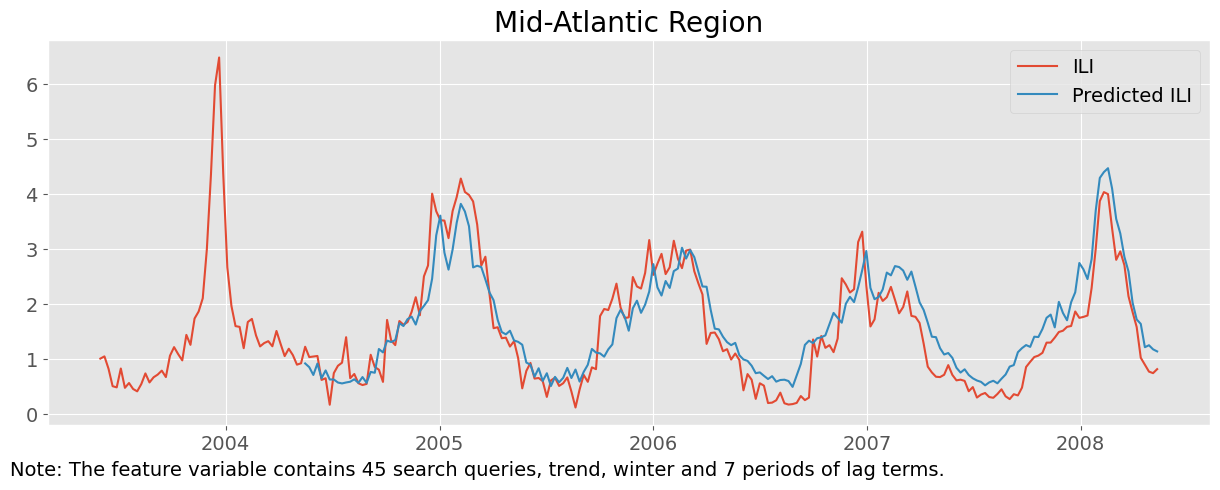

In [15]:
# search queries + trend + winter + lag_1 + ... + lag_7
X = dat.drop( ['date', 'y'], axis = 1) 

note = 'Note: The feature variable contains 45 search queries, trend, winter and 7 periods of lag terms.'
train_the_model(X)

## Predictions for other regional search query data
Although visually, after training the model with queries data from the Mid-Atlantic Region, it can effectively predict the CDC's ILI activity level, but I thought that due to the differences between regions, such as Internet access, population structure, distribution of medical resources, culture and behavior, if based on the same feature selection, can the model generalize to data from other regions?

Create a class to encapsulate the construction of the dataset and allow users to directly enter region selection values

In [16]:
class DatasetConstructor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.dat = None

    def construct_dataset(self, area):
        pred_data = self.file_path + "41586_2009_BFnature07634_MOESM271_ESM.xls"
        df = pd.read_excel(pred_data, sheet_name=1, header=1)

        # Combine 45 queries
        dict = {'date': df['Date'].tolist()}
        for i in range(1, 46):
            if i % 5 == 0:
                print(i)
            df_sheet = pd.read_excel(pred_data, sheet_name=i, header=1)
            dict['query'+str(i)] = df_sheet[area].tolist()
        self.dat = pd.DataFrame.from_dict(dict)

        # Convert time series data columns to datetime type
        self.dat['date'] = pd.to_datetime(self.dat['date'])

        # Read real ILI Value
        df = {}
        for i in range(0, 7):
            full_path = self.file_path + "FluView_LineChart_Data-{}.csv".format(i)
            df[i] = pd.read_csv(full_path, skiprows=1)

        y = pd.concat([df[0], df[1], df[2], df[3], df[4], df[5], df[6]])
        y = y[y['YEAR'] > 2002]
        y = y[((y['YEAR'] == 2003) & (y['WEEK'] > 22)) | (y['YEAR'] > 2003)][:len(self.dat['date'])]
        y = y['% WEIGHTED ILI']

        self.dat['y'] = y.tolist()  # store y into *dat* dataset
        
        # create covariates that may affect the ILI value
        # create a time trend
        self.dat['trend'] = range(1,len(self.dat)+1)

        # create a dummy variable indicating winter season
        self.dat['winter'] = [1 if i.month in [12, 1, 2] else 0 for i in self.dat['date'] ]

        # create lagged variables
        for i in range(1, 8):
            self.dat["lag_{}".format(i)] = self.dat['y'].shift(i)

        # Fill the database with all missing values to 0.
        self.dat = self.dat.fillna(0)

        return self.dat

### Usage for Pacific Region

5
10
15
20
25
30
35
40
45
Best alpha: 0.00488576
Best l1_ratio: 0.500
Iterations 219
Train r2 score:  0.9958823325082414
Test r2 score:  0.31194604360281575
Train RMSE: 0.0809
Test RMSE: 0.6631


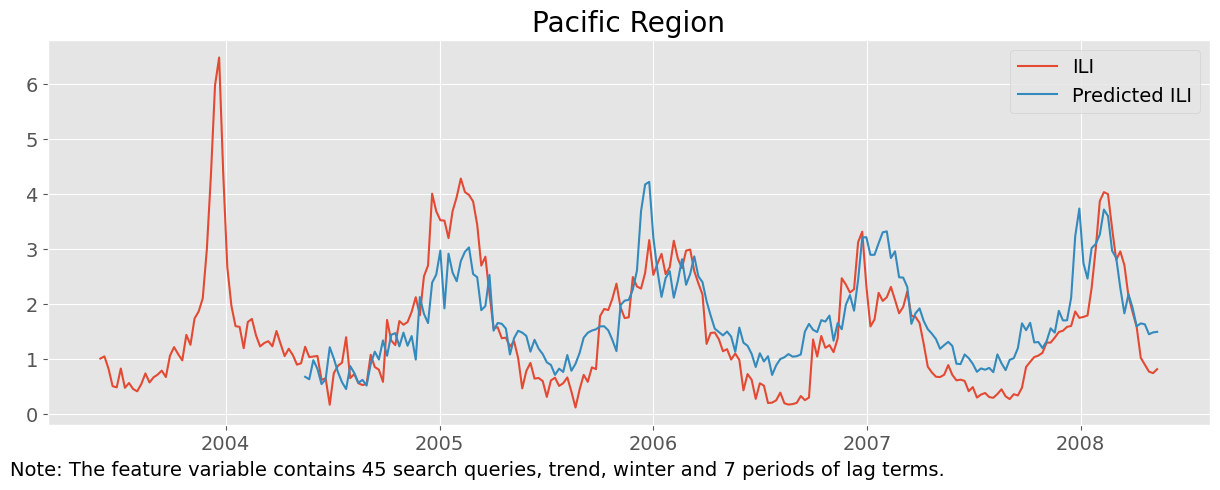

In [17]:
file_path = "E:/2024计算社会科学夏校/hw/day6/"
constructor = DatasetConstructor(file_path)
area = 'Pacific Region' 
dat = constructor.construct_dataset(area)

# search queries + trend + winter + lag_1 + ... + lag_7
X = dat.drop( ['date', 'y'], axis = 1) 
note = 'Note: The feature variable contains 45 search queries, trend, winter and 7 periods of lag terms.'
train_the_model(X)

### Usage for West South Central Region

5
10
15
20
25
30
35
40
45
Best alpha: 0.04145620
Best l1_ratio: 0.500
Iterations 47
Train r2 score:  0.9508326577374281
Test r2 score:  0.8038244376646462
Train RMSE: 0.2648
Test RMSE: 0.3795


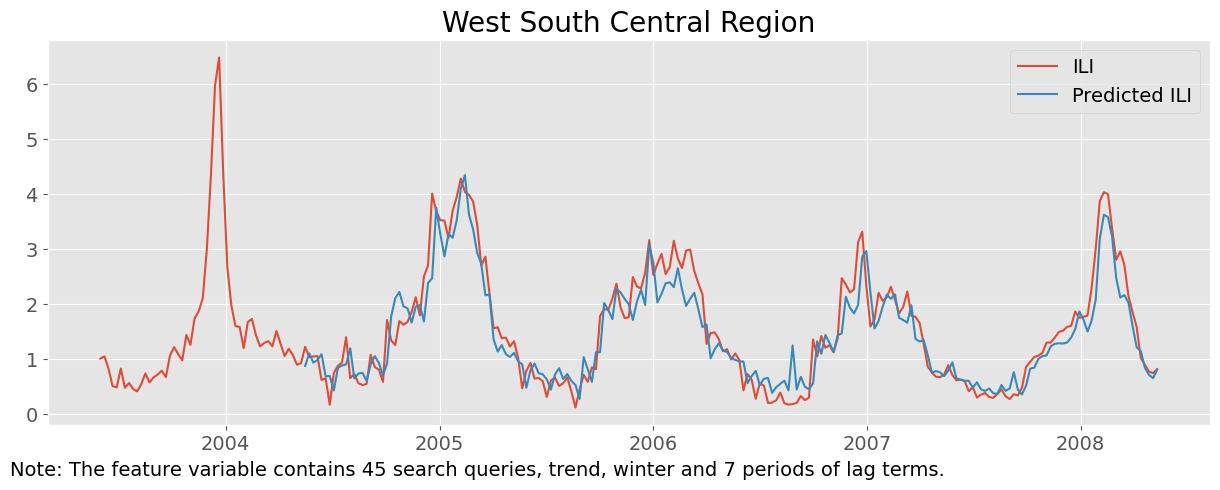

In [18]:
file_path = "E:/2024计算社会科学夏校/hw/day6/"
constructor = DatasetConstructor(file_path)
area = 'West South Central Region' 
dat = constructor.construct_dataset(area)

# search queries + trend + winter + lag_1 + ... + lag_7
X = dat.drop( ['date', 'y'], axis = 1) 
note = 'Note: The feature variable contains 45 search queries, trend, winter and 7 periods of lag terms.'
train_the_model(X)

### Usage for New England Region

5
10
15
20
25
30
35
40
45
Best alpha: 0.00796897
Best l1_ratio: 0.500
Iterations 89
Train r2 score:  0.9921430589612795
Test r2 score:  0.15948720978018704
Train RMSE: 0.1115
Test RMSE: 0.5889


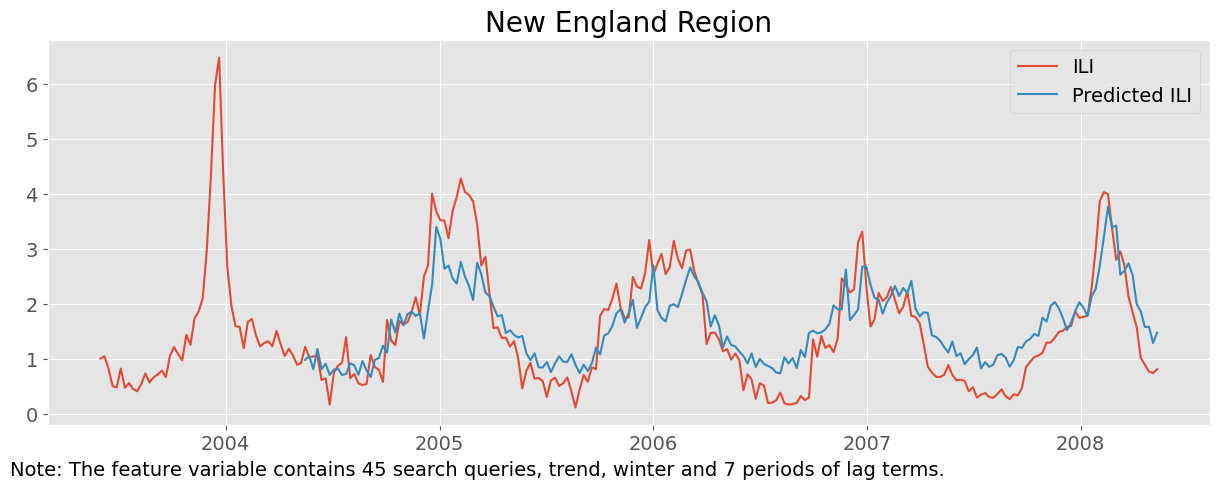

In [19]:
file_path = "E:/2024计算社会科学夏校/hw/day6/"
constructor = DatasetConstructor(file_path)
area = 'New England Region' 
dat = constructor.construct_dataset(area)

# search queries + trend + winter + lag_1 + ... + lag_7
X = dat.drop( ['date', 'y'], axis = 1) 
note = 'Note: The feature variable contains 45 search queries, trend, winter and 7 periods of lag terms.'
train_the_model(X)


### Usage for United States

5
10
15
20
25
30
35
40
45
Best alpha: 0.00759830
Best l1_ratio: 0.500
Iterations 360
Train r2 score:  0.9907694738494224
Test r2 score:  0.6497056984159417
Train RMSE: 0.1208
Test RMSE: 0.5189


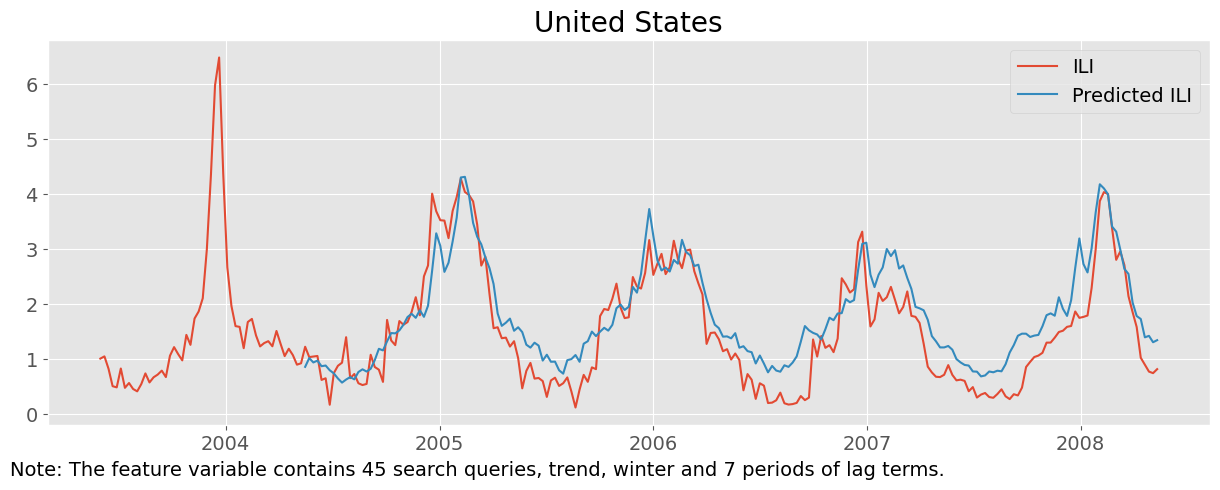

In [20]:
file_path = "E:/2024计算社会科学夏校/hw/day6/"
constructor = DatasetConstructor(file_path)
area = 'United States' 
dat = constructor.construct_dataset(area)

# search queries + trend + winter + lag_1 + ... + lag_7
X = dat.drop( ['date', 'y'], axis = 1) 
note = 'Note: The feature variable contains 45 search queries, trend, winter and 7 periods of lag terms.'
train_the_model(X)


### Usage for East North Central Region

5
10
15
20
25
30
35
40
45
Best alpha: 0.02109792
Best l1_ratio: 0.500
Iterations 195
Train r2 score:  0.984178568855513
Test r2 score:  0.6291075306803935
Train RMSE: 0.1573
Test RMSE: 0.5580


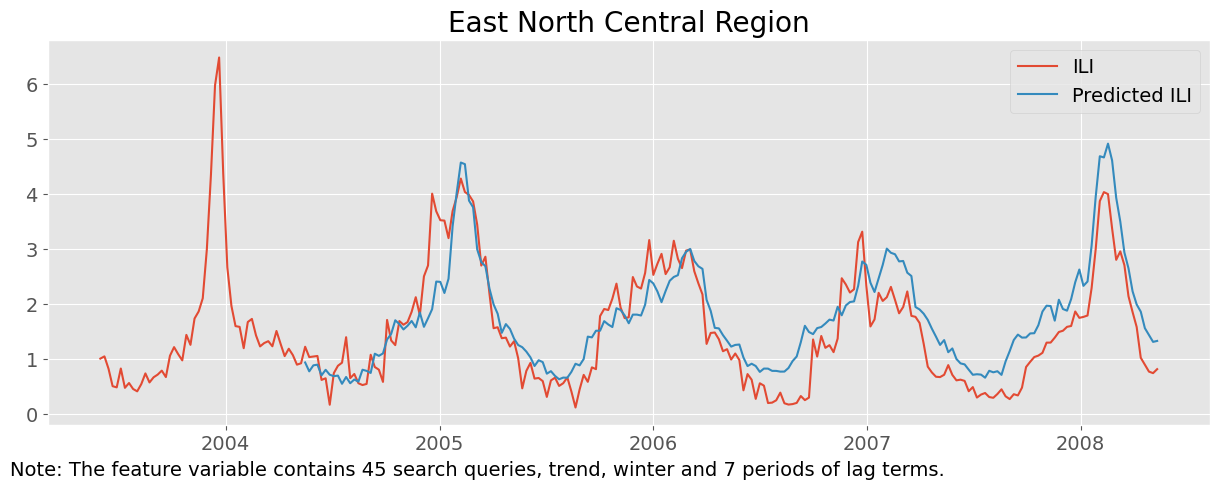

In [21]:
file_path = "E:/2024计算社会科学夏校/hw/day6/"
constructor = DatasetConstructor(file_path)
area = 'East North Central Region' 
dat = constructor.construct_dataset(area)

# search queries + trend + winter + lag_1 + ... + lag_7
X = dat.drop( ['date', 'y'], axis = 1) 
note = 'Note: The feature variable contains 45 search queries, trend, winter and 7 periods of lag terms.'
train_the_model(X)

## Findings and Thinking
The analysis shows that when using search query data from different regions to predict influenza-like illness (ILI) trends reported by the US Centers for Disease Control and Prevention (CDC), the model's performance varies significantly even with the same characteristic variables.

**Possible Reasons for Variation**  
1. **Regional Differences in Search Behavior**: Cultural habits, access to healthcare, and language use differ across regions, influencing how people search for health information. For instance, some regions may use local slang or rely on home remedies, reducing online searches in early symptom stages.  
2. **Epidemic Variations by Region**: The prevalent ILI strains, symptom severity, and local health concerns differ, leading to variations in search terms. For example, severe respiratory symptoms in certain areas may drive specific search patterns not captured by other regions' data.  
3. **Population Structure Differences**: Factors like age, education, and occupation impact search habits. Younger populations might rely more on online searches, while older populations may prefer traditional medical channels, causing disparities in search data relevance.  
4. **Internet Usage Patterns**: Internet penetration, speed, and usage habits vary, affecting the volume and representativeness of search data in different regions.

**Potential Solutions to Improve Generalization**  
1. **Localized Feature Adjustments**: Tailor model features to regional search behaviors, epidemic characteristics, and population structures.  
2. **Multi-Source Data Integration**: Incorporate additional data sources, such as local drug sales or outpatient visits, to complement and verify search data, reducing biases from single-source reliance.

Ultimately, these solutions require customization for the deployment context. **Developing robust, reliable, explainable, and safe machine learning algorithms** remains the key to enhancing model generalization.